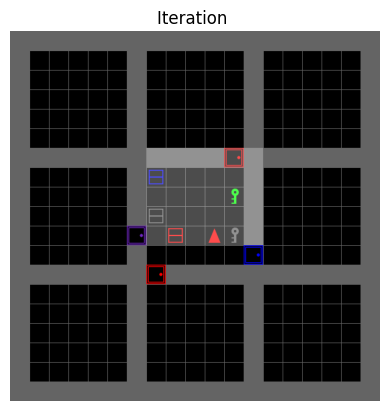

Knowledge Base:
Room 0 is empty
Room 1:
  red door is at (11, 6) and is currently closed
Room 2 is empty
Room 3:
  purple door is at (6, 10) and is currently closed
Room 4:
  blue box is at (7, 7)
  grey box is at (7, 9)
  red box is at (8, 10)
  green key is at (11, 8)
  grey key is at (11, 10)
  red door is at (11, 6) and is currently closed
  purple door is at (6, 10) and is currently closed
  blue door is at (12, 11) and is currently closed
  red door is at (7, 12) and is currently closed
Room 5:
  blue door is at (12, 11) and is currently closed
Room 6 is empty
Room 7:
  red door is at (7, 12) and is currently closed
Room 8 is empty

Connections:
Room 1 connect to Room 4 by red door at (11, 6) which is currently closed
Room 3 connect to Room 4 by purple door at (6, 10) which is currently closed
Room 4 connect to Room 5 by blue door at (12, 11) which is currently closed
Room 4 connect to Room 7 by red door at (7, 12) which is currently closed
Robot location: (10, 10)
Mission: pick 

In [ ]:
%reload_ext autoreload
%autoreload 2
import random
from VLA2Systems.task_data_generator import TaskDataGenerator
# Using a simple list
# env_list = ["MiniGrid-DoorKey-16x16-v0", "MiniGrid-MultiRoom-N6-v0"]
env_list = ["BabyAI-OneRoomS8-v0", "BabyAI-ActionObjDoor-v0"]

generator = TaskDataGenerator(env_list)
seed = random.randint(1, 1000)
generator.reset(seed=seed)
plan = generator.generate_plan()
if plan:
    text = generator.plan2text(include_all=True)
    print(text)
else:
    print("Planning Failed")


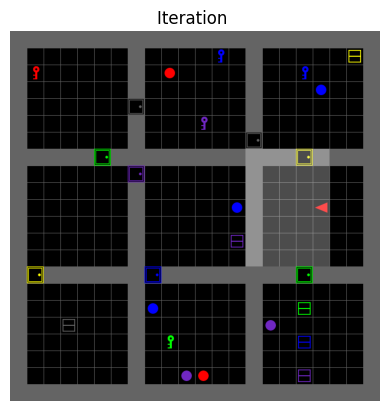


Plan is: 
Step 1: Open green door
Step 2: Pick up blue box
Step 3: Go to green door
Step 4: Open yellow door
Step 5: Open grey door
Step 6: Drop blue box next to red ball


In [ ]:
# Using a difficulty-based dictionary
env_dict = {
    "easy": ["BabyAI-ActionObjDoor-v0"],
    "intermediate": ["BabyAI-FindObjS5-v0"],
    "hard": ["BabyAI-UnlockToUnlock-v0", "BabyAI-Synth-v0"]
}
generator = TaskDataGenerator(env_dict)
generator.reset(difficulty="hard")  # Select from "hard" list
generator.generate_plan()
generator.visualize()
if plan:
    generator.plan2text(print_plan=True)
else:
    print("Planning Failed")
